In [2]:
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import defmodel, extend_model,prop2d_cpu
from func.inversion import second_order_derivative
from func.velocity_model import check_model, gaussian2d

precision = np.float32
device = 'cpu'

def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec = np.unique(zxrec,axis=1)

  return zxrec

In [3]:
def prop2d(wsrc, zxsrc, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""

	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		# Calculate source waveform
		wsrc = np.array([wsrc], dtype=precision) if wsrc.ndim == 1 else np.array(wsrc, dtype=precision) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array
		pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
		pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc # insert source wavelet

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,next2)

		# Shift the source by next
		asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2], dtype=precision)
		pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
		pp    = np.zeros([nze,nxe], dtype=precision)
		fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

		# Construct the sparse Laplacian matrix
		nze = nz + 2 * next2
		nxe = nx + 2 * next2

		# Calculate the size of the Laplacian matrix
		nzz, nxx = nz + 2*next, nx + 2*next
		size = nzz * nxx

		# Construct the Laplacian matrix
		diagonal = -2*np.ones(size)*(_dz2+_dx2)
		off_diagonal_x = np.ones(size - 1) * _dz2
		off_diagonal_z = np.ones(size - nxx) * _dx2

		# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
		off_diagonal_x[nxx - 1::nxx] = 0
		off_diagonal_z[-nxx:] = 0

		# Create the Laplacian matrix L using the diagonal and off-diagonal values
		L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
								[-1, -nxx, 0, nxx, 1], shape=(size, size))

		# Create the Transform matrix T using wave equation
		T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')

		d_obs = [np.zeros(zxrec.shape[1])]
		p = [np.zeros((nz,nx))]

		for it in range(1,nt-1): # From 1 to nt-1
			pt = pp.copy()
			# ptwsrc = np.zeros((nz,nx))
			# ptwsrc[zxsrc[0,:], zxsrc[1,:]] = extend_wsrc[it]
			# asrc[next:-next,next:-next] = ptwsrc[1:-1,1:-1]      
			asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]		#	0.0002s
			pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
							T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1]   \
							- pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
							+ asrc * fact[1:-1, 1:-1]   
			pm = pt

			# One-way equation (bottom part)
			pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
							vele[nze-1-nabs:nze,:nxe]*dt/dz* \
							(pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
			# One-way equation (top part)
			pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
							vele[:1+nabs,:nxe]*dt/dz* \
							(pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
			# One-way equation (right part)
			pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
							vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
			(pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
			# One-way equation (left part)
			pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
							vele[:nze,:1+nabs]*dt/dx* \
							(pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])

			d_obs.append(pp[next2:nze-next2,next2:nxe-next2][zxrec[0], zxrec[1]])
			p.append(pp[next2:nze-next2,next2:nxe-next2].copy())

		d_obs.append(np.zeros(zxrec.shape[1]))
		d_obs = np.array(d_obs).T
		p.append(np.zeros((nz,nx)))
		p = np.moveaxis(np.array(p), 0, -1)

	return p, d_obs

def J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,vel,at,az,ax,next,device)
	residual = d - d_obs
	J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
	print("J =", J)

	return J

def gradiant(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	nz, nx, nt = len(az), len(ax), len(at)
	if vel.ndim == 1: vel = np.reshape(vel,(nz,nx))
	p_fwd, d = prop2d(wsrc,zxsrc,vel,at,az,ax,next,device)
	receiver_depth = zxrec[0]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()

In [4]:
import numpy as np
[np.zeros((5,5))].append(np.zeros((5,5)))

Min velocity: 2500.00  Max velocity 2800.00
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  100 300 500


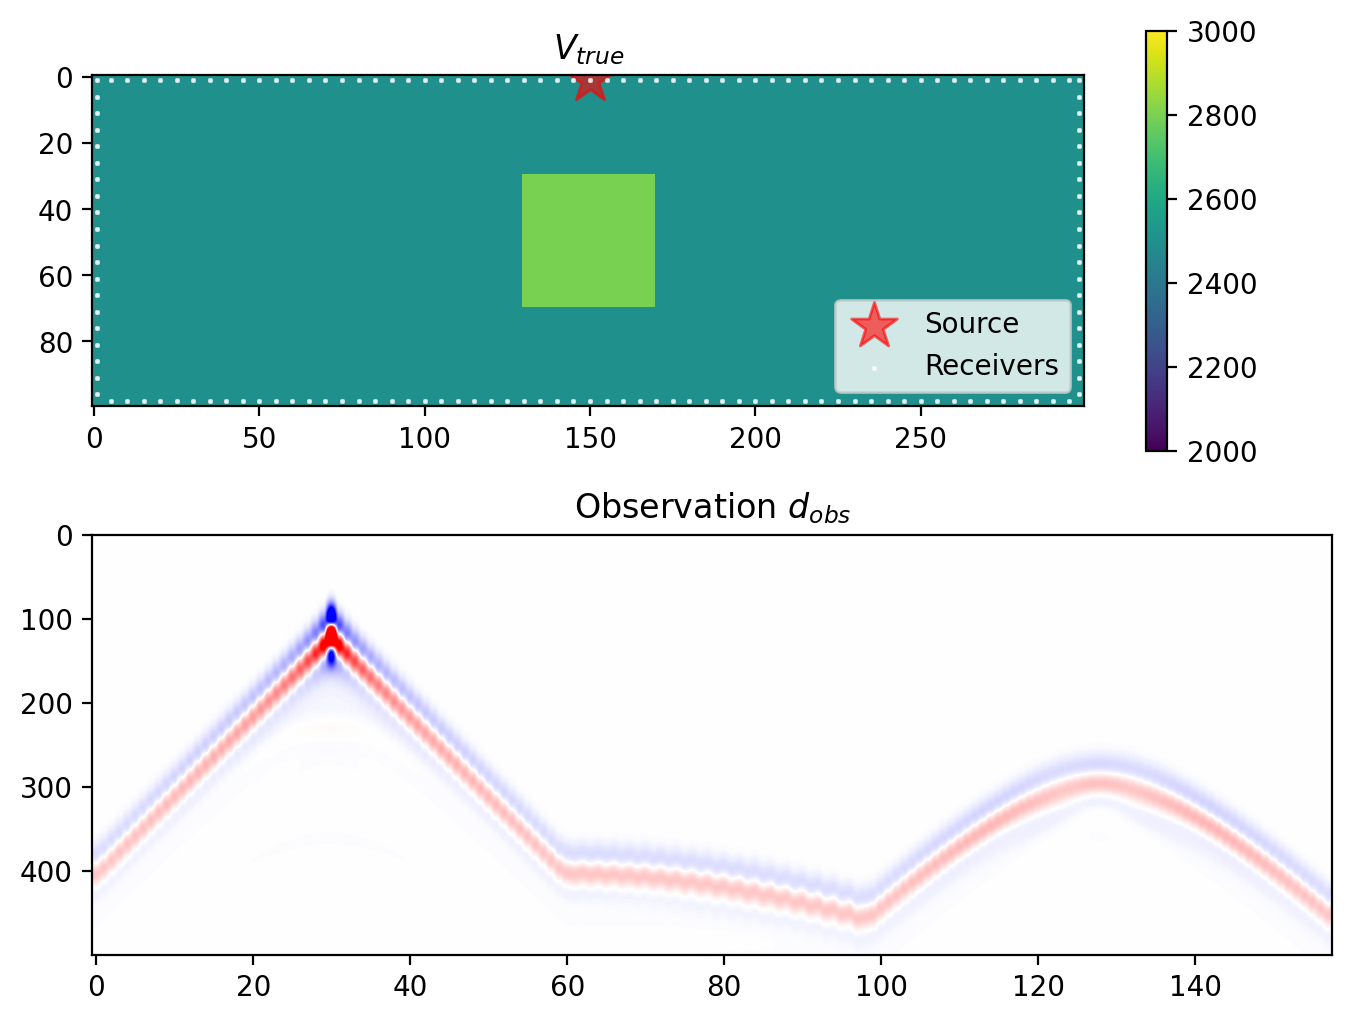

In [10]:
# Model size (nz,nx) = (200,200)

# import pickle
# # load data
# filename = './data/u_200'
# infile = open(filename, 'rb')
# u_ref = pickle.load(infile)
# infile.close()

# # u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
# v_ref = f(u_ref)

# # Initialize the model axis az, ax, at
# nz,nx,nt = 200,200,800
# vmin,vmax = 2000,3000
# izsrc, ixsrc = [nz//100], [nx//2]
# next = 100

# Create a new velocity field
nz,nx,nt = 100,300,500
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100
ve= np.ones((100, 300)) * 2500
ve[30:70, 130:170] = 2800
v_ref = ve

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)


plt.figure(figsize=(8,6), dpi=200)
plt.subplot(2,1,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(2,1,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10, aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

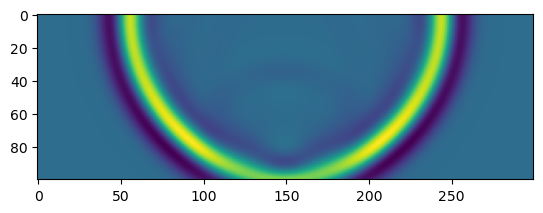

In [12]:
plt.imshow(p[:,:,300])

In [9]:
# optimize cost function
v_init = np.zeros([nz*nx]) + 2500   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = J, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant, # Jacobian / gradiant
               options = {'disp':True, 'maxiter':150},
              )
v_fwi = resi.x
print(v_fwi.shape)

J =  827.3329474535565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27333D+02    |proj g|=  2.96431D-02
J =  827.2395939222293

At iterate    1    f=  8.27240D+02    |proj g|=  2.96386D-02
J =  138.62460317545109

At iterate    2    f=  1.38625D+02    |proj g|=  8.45534D-03
J =  90.76783611732209

At iterate    3    f=  9.07678D+01    |proj g|=  8.62463D-03
J =  55.83037643255334

At iterate    4    f=  5.58304D+01    |proj g|=  3.45588D-03
J =  39.224653230206854

At iterate    5    f=  3.92247D+01    |proj g|=  3.81433D-03
J =  22.513821190436023

At iterate    6    f=  2.25138D+01    |proj g|=  3.31956D-03
J =  18.619593230116713

At iterate    7    f=  1.86196D+01    |proj g|=  1.12704D-03
J =  14.75454301072527

At iterate    8    f=  1.47545D+01    |proj g|=  9.48380D-04
J =  11.749858141654045

At iterate    9    f=  1.17499D+01    |

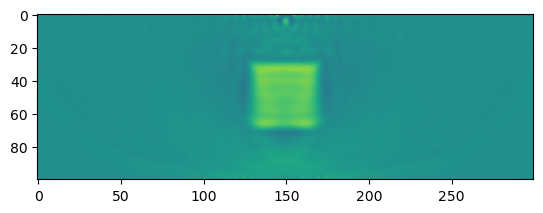

In [10]:
plt.imshow(v_fwi.reshape((nz,nx)),vmin=2000,vmax=3000)

## New code (Matrix) 200x200

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 1200
  (0, 0)	0.9586802357702913
  (0, 400)	0.2603299410574272
  (0, 1)	0.2603299410574272
  (1, 0)	0.2603299410574272
  (1, 1)	0.9586802357702913
  (1, 401)	0.2603299410574272
  (1, 2)	0.2603299410574272
  (2, 1)	0.2603299410574272
  (2, 2)	0.9586802357702913
  (2, 402)	0.2603299410574272
  (2, 3)	0.2603299410574272
  (3, 2)	0.2603299410574272
  (3, 3)	0.9586802357702913
  (3, 403)	0.2603299410574272
  (3, 4)	0.2603299410574272
  (4, 3)	0.2603299410574272
  (4, 4)	0.9586802357702913
  (4, 404)	0.2603299410574272
  (4, 5)	0.2603299410574272
  (5, 4)	0.2603299410574272
  (5, 5)	0.9586802357702913
  (5, 405)	0.2603299410574272
  (5, 6)	0.2603299410574272
  (6, 5)	0.2603299410574272
  (6, 6)	0.9586802357702913
  :	:
  (159991, 159991)	0.3816113982120195
  (159991, 159992)	0.4045971504469951
  (159992, 159991)	0.4045971504469951
  (159992, 159992)	0.3816113982120195
 

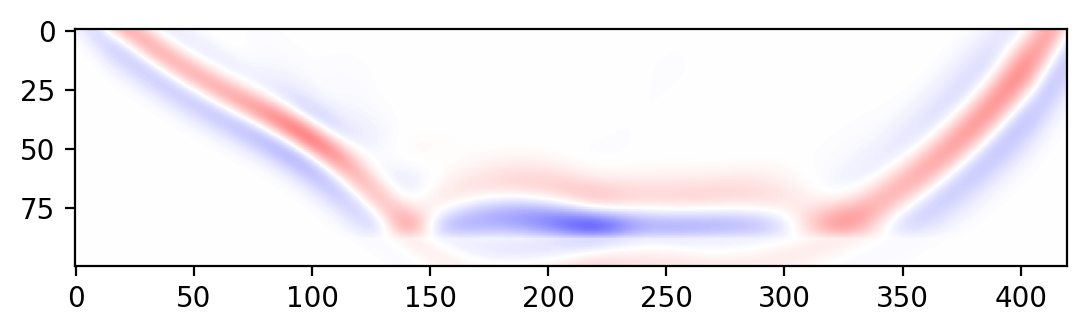

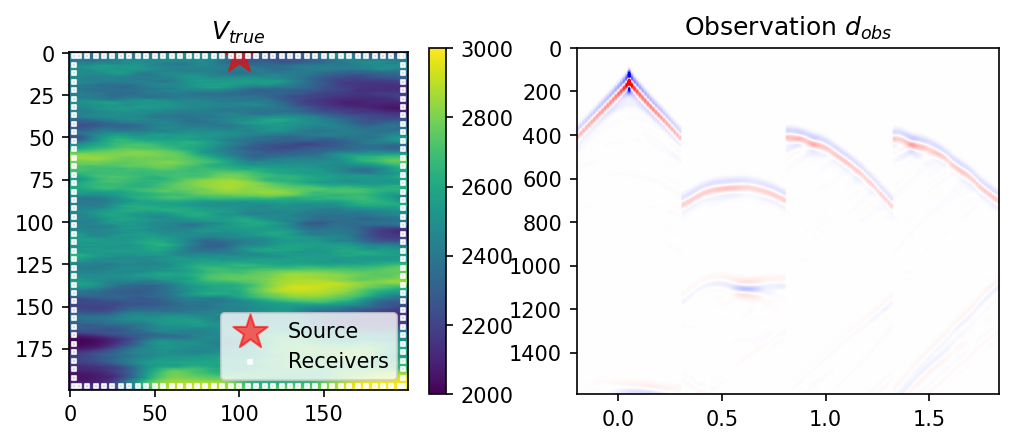

In [15]:
from IPython.display import clear_output
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
labelsize = 16

from func.propagation_matrix import defmodel, J, second_order_derivative

precision = np.float64
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]

def extend_model(vel,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	nz   = np.shape(vel)[0]
	nx   = np.shape(vel)[1]
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe])
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele

def prop2d(wsrc, zxsrc, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""

	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		# Calculate source waveform
		wsrc = np.array([wsrc], dtype=precision) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array
		pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
		pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc # insert source wavelet

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,next2)

		# plt.imshow(vele)
		# plt.colorbar()
		# plt.show()


		# Shift the source by next
		asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
		pm    = np.zeros([nze,nxe]) # Previous wave field
		pt    = np.zeros([nze,nxe])
		pp    = np.zeros([nze,nxe])
		fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

		# Construct the sparse Laplacian matrix
		nze = nz + 2 * next2
		nxe = nx + 2 * next2

		# Calculate the size of the Laplacian matrix
		nzz, nxx = nz + 2*next, nx + 2*next
		size = nzz * nxx

		# Construct the Laplacian matrix
		diagonal = -2*np.ones(size)*(_dz2+_dx2)
		off_diagonal_x = np.ones(size - 1) * _dz2
		off_diagonal_z = np.ones(size - nxx) * _dx2

		# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
		off_diagonal_x[nxx - 1::nxx] = 0
		off_diagonal_z[-nxx:] = 0

		# Create the Laplacian matrix L using the diagonal and off-diagonal values
		L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
								[-1, -nxx, 0, nxx, 1], shape=(size, size))

		# Create the Transform matrix T using wave equation
		T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')


		print(T)

		# d_obs = [np.zeros(zxrec.shape[1])]
		p = [np.zeros((nze,nxe))]
		p.append(np.zeros((nze,nxe)))


		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			pp = np.zeros([nze,nxe])
			
			asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]		#	0.0002s
			pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
							T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1]   \
							- pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
							+ asrc * fact[1:-1, 1:-1]   
			
			# if it==610:
			# 	# print(pp()) 
			# 	plt.figure(dpi=200)
			# 	plt.imshow(pp)
			
			# One-way equation (bottom part)
			pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
							vele[nze-1-nabs:nze,:nxe]*dt/dz* \
							(pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
			
			# One-way equation (top part)
			pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
							vele[:1+nabs,:nxe]*dt/dz* \
							(pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
			# One-way equation (right part)
			pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
							vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
			(pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
			# One-way equation (left part)
			pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
							vele[:nze,:1+nabs]*dt/dx* \
							(pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])
			
						
			if it==670:
				# print(pp()) 
				plt.figure(dpi=200)
				plt.imshow(pp[-100:,:],cmap='bwr',vmin=-5,vmax=5)
			
			p.append(pp.copy())
			# p.append(pp[next2:nze-next2,next2:nxe-next2].copy())

		p = np.moveaxis(np.array(p), 0, -1)
		p_inter = p[next2:nze-next2,next2:nxe-next2,:]
		print(p.shape)
		d_obs = p_inter[zxrec[0], zxrec[1], :]

	return p_inter, d_obs


import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,1200
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers

receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down

zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,3),dpi=150)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

### Test for new code

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 1200
(420, 420, 1200)


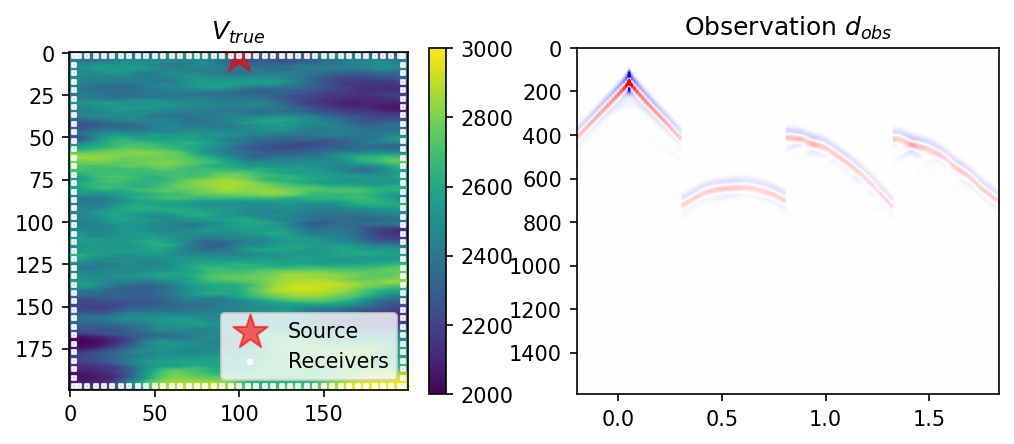

In [18]:
from IPython.display import clear_output
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
labelsize = 16

from func.propagation_matrix import defmodel, J, second_order_derivative

precision = np.float64
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]

def extend_model(vel,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	nz   = np.shape(vel)[0]
	nx   = np.shape(vel)[1]
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe])
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele

def prop2d(wsrc, zxsrc, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""

	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		# Calculate source waveform
		wsrc = np.array([wsrc], dtype=precision) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array
		pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
		pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc # insert source wavelet

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,next2)

		# plt.imshow(vele)
		# plt.colorbar()
		# plt.show()


		# Shift the source by next
		asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
		pm    = np.zeros([nze,nxe]) # Previous wave field
		pt    = np.zeros([nze,nxe])
		pp    = np.zeros([nze,nxe])
		fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

		# Construct the sparse Laplacian matrix
		nze = nz + 2 * next2
		nxe = nx + 2 * next2

		# Calculate the size of the Laplacian matrix
		nzz, nxx = nz + 2*next, nx + 2*next
		size = nzz * nxx + 2 * nxx

		# Construct the Laplacian matrix
		diagonal = -2*np.ones(size)*(_dz2+_dx2)
		off_diagonal_x = np.ones(size - 1) * _dz2
		off_diagonal_z = np.ones(size - nxx) * _dx2

		# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
		off_diagonal_x[nxx - 1::nxx] = 0
		off_diagonal_z[-nxx:] = 0

		# Create the Laplacian matrix L using the diagonal and off-diagonal values
		L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
								[-1, -nxx, 0, nxx, 1], shape=(size, size))

		# Create the Transform matrix T using wave equation
		T = sp.diags(np.pad(fact.flatten(), nxx), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')

		# d_obs = [np.zeros(zxrec.shape[1])]
		p = [np.zeros((nze,nxe))]
		p.append(np.zeros((nze,nxe)))


		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			pp = np.zeros([nze,nxe])
			
			asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]		#	0.0002s
			pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
							T.dot(np.pad(pt[nabs:-nabs, nabs:-nabs].flatten(), nxx))[nxx:-nxx].reshape(nzz, nxx)[1:-1, 1:-1]   \
							- pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
							+ asrc * fact[1:-1, 1:-1]   

			# One-way equation (bottom part)
			pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
							vele[nze-1-nabs:nze,:nxe]*dt/dz* \
							(pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
			
			# One-way equation (top part)
			pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
							vele[:1+nabs,:nxe]*dt/dz* \
							(pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
			# One-way equation (right part)
			pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
							vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
			(pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
			# One-way equation (left part)
			pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
							vele[:nze,:1+nabs]*dt/dx* \
							(pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])
			
			p.append(pp.copy())
			# p.append(pp[next2:nze-next2,next2:nxe-next2].copy())

		p = np.moveaxis(np.array(p), 0, -1)
		p_inter = p[next2:nze-next2,next2:nxe-next2,:]
		print(p.shape)
		d_obs = p_inter[zxrec[0], zxrec[1], :]

	return p_inter, d_obs


import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,1200
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers

receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down

zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,3),dpi=150)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [ ]:
import time

for i in range(50):
  clear_output(wait=True)
  iter = 1200//50 * i
  lim = 4
  plt.figure()
  plt.imshow(p[:,:,iter],cmap='bwr',vmin=-lim, vmax=lim)
  plt.colorbar()
  plt.show()
  time.sleep(0.2)

## Old code

2023-06-12 15:52:19.404878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 15:52:19.917800: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 15:52:21.480157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-06-12 15:52:21.480274: W tensorflow/comp

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 1200


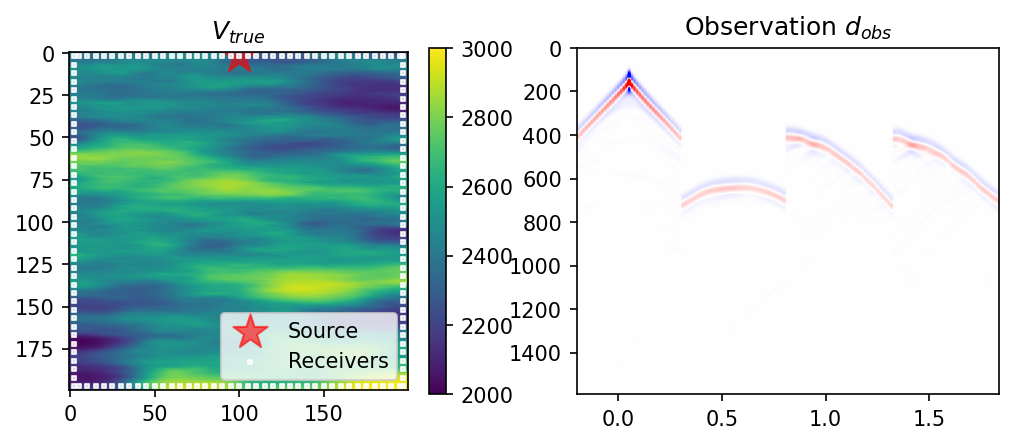

In [1]:
from IPython.display import clear_output
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from func.propagation import prop2d, defmodel

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics.pairwise import pairwise_distances
from sksparse.cholmod import cholesky

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

precision = np.float64
device = 'cpu'


# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]


def sample_from_Qmat(Qmat, num_samples):

  factor = cholesky(Qmat)
  # Generate independent standard normal random variables
  u = np.random.standard_normal((Qmat.shape[0], num_samples))
  # Apply Cholesky factorization operations and permutation
  samples = factor.apply_Pt(factor.solve_DLt(u))
  
  return np.swapaxes(samples,0,1)


import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,1200
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
nrec = len(receivers_width)
zxrec = receiver_position(1)

p2 = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs2 = p2[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3),dpi=150)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs2.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

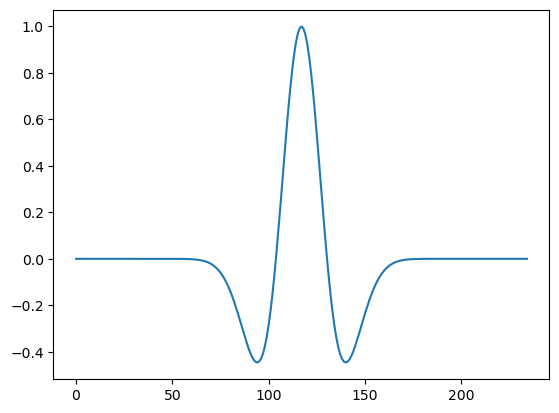

In [4]:
plt.plot(wsrc)

-2.3999020671960087e-05 -9.704489862113827e-16


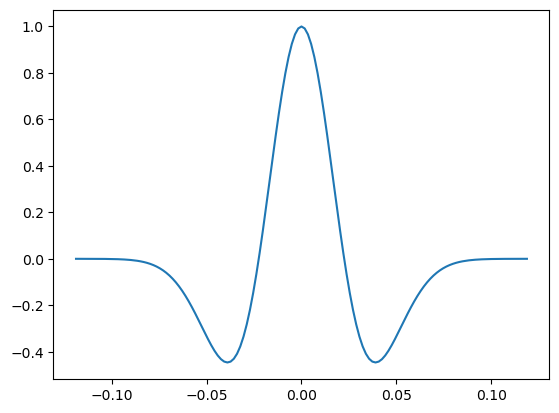

In [2]:
from math import pi, exp
def defsrc(fmax, dt):
	"""
	Definition of the source (Ricker) function
	Ricker wavelet with central frequency fmax/2.5
	Ricker = 2nd-order derivative of a Gaussian function
	Advantage: the frequency content of that shape is controlled by the fmax argument
	"""
	fc   = fmax / 2.5    # Central frequency
	ns2  = int(1.2/fc/dt)
	ns   = 1 + 2*ns2     # Size of the source
	wsrc = np.zeros(ns)
	aw   = np.zeros(ns)  # Time axis
	for it in range(ns):
		a1 = float(it-ns2)*fc*dt*pi
		a2 = a1**2
		wsrc[it] = (1-2*a2)*exp(-a2)
		aw[it]   = float(it-ns2)*dt
	return wsrc, aw

wsrc2, aw2 = defsrc(25, dt)

plt.plot(aw2, wsrc2)
print(wsrc2[0],wsrc[0])

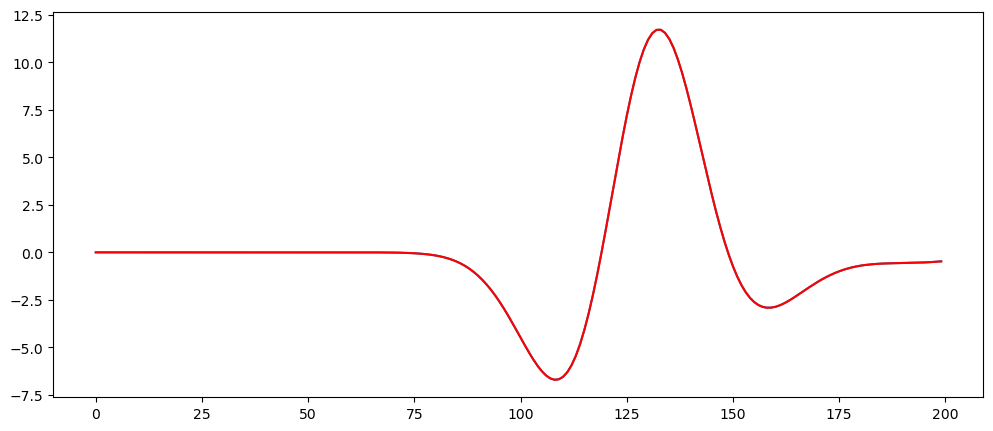

In [6]:
plt.figure(figsize=(12,5))
plt.plot(d_obs2[20,:200])
plt.plot(d_obs[20,:200],'r') # New code
# plt.plot(d_obs2[20,:200]-d_obs[20,:200])

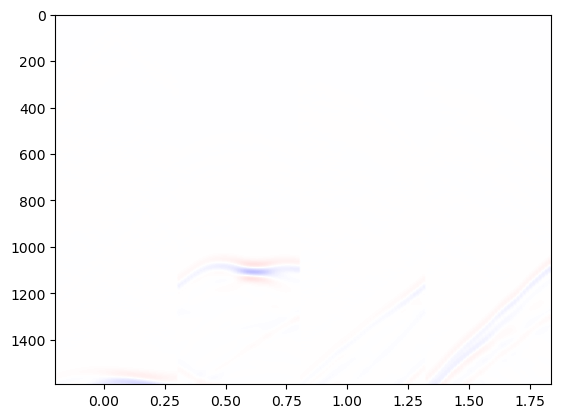

In [4]:
plt.imshow(d_obs.T - d_obs2.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')


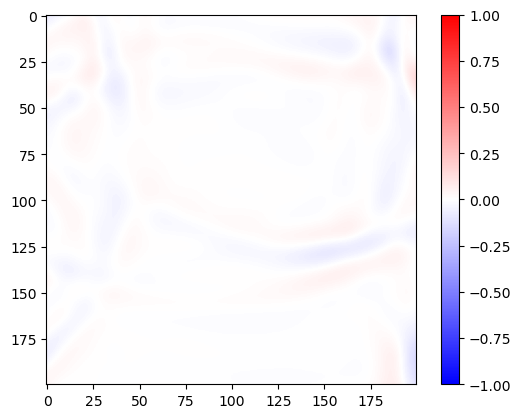

In [34]:
range = 1
plt.imshow(p2[:,:,799],cmap='bwr',vmin=-range, vmax=range)
plt.colorbar()

## Test code I

In [12]:
import numpy as np
import scipy.sparse as sp

# Create a new velocity field
nz,nx,nt = 100,300,800
ve= np.ones((100, 300)) * 2500
ve[20:80, 120:180] = 2800
vel = ve

wsrc = np.array([wsrc]) if wsrc.ndim == 1 else wsrc # convert source wavelet from 1d to 2d
pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc # insert source wavelet

next = 100
"""
2d wave propagation
Resolution with finite differences
Orders 2 in time and space
with absorbing boundaries (Clayton and Engquist)
Vectorial implementation (much faster)
"""
nabs  = 10
next2 = nabs + next
nt    = len(at)
nz    = len(az)
nx    = len(ax)
dz    = az[1] - az[0]
dx    = ax[1] - ax[0]
dt    = at[1] - at[0]   
_dz2   = 1./dz**2
_dx2   = 1./dx**2

# Extend the model
nze  = nz + 2*next2
nxe  = nx + 2*next2
vele = extend_model(vel,next2)

# Shift the source by next
asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
pp    = np.zeros([nze,nxe], dtype=precision)
fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

# Construct the sparse Laplacian matrix
nze = nz + 2 * next2
nxe = nx + 2 * next2

# Calculate the size of the Laplacian matrix
nzz, nxx = nz + 2*next, nx + 2*next
size = nzz * nxx

# Construct the Laplacian matrix
diagonal = -2*np.ones(size)*(_dz2+_dx2)
off_diagonal_x = np.ones(size - 1) * _dz2
off_diagonal_z = np.ones(size - nxx) * _dx2

# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
off_diagonal_x[nxx - 1::nxx] = 0
off_diagonal_z[-nxx:] = 0

# Create the Laplacian matrix L using the diagonal and off-diagonal values
L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
             [-1, -nxx, 0, nxx, 1], shape=(size, size))
# Create the Transform matrix T using wave equation
T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')

d_obs = []
p = [np.zeros((nz,nx))]

for it in range(1,nt-1): # From 1 to nt-1
        pt = pp.copy()
        
        asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]

        pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
                T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1] \
                - pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
                + asrc * fact[1:-1, 1:-1]   
        pm = pt

        # One-way equation (bottom part)
        pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
                vele[nze-1-nabs:nze,:nxe]*dt/dz* \
                (pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
        # One-way equation (top part)
        pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
                vele[:1+nabs,:nxe]*dt/dz* \
                (pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
        # One-way equation (right part)
        pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
                vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
        (pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
        # One-way equation (left part)
        pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
                vele[:nze,:1+nabs]*dt/dx* \
                (pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])

        d_obs.append(pp[next2:nze-next2,next2:nxe-next2][zxrec[1], zxrec[0]])
        p.append(pp[next2:nze-next2,next2:nxe-next2].copy())

d_obs = np.array(d_obs).T
p.append(np.zeros((nz,nx)))
p = np.moveaxis(np.array(p), 0, -1)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')

IndexError: index 100 is out of bounds for axis 0 with size 100